# SImulation CLP PID FF

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import matplotlib.gridspec as gridspec

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import LL_RT, PID_RT, IMCTuning
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

# Parameters

In [122]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 58

Kp= 0.3578141359884931
T1= 182.46415297298876
T2= 12.839231012953283
thetap= 8.32912593907378


Kd=  0.25983971364459724
T1d = 255.2308010928982
T2d = 19.07109604060042
thetad = 30.999999996157488

#Process
P = Process({})
P.parameters['Kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1
P.parameters['Tlag2'] = T2
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0



gamma = 0.7
Kc, Ti, Td = IMCTuning(Kp, T1, T2, thetap, gamma, 'SOPDT')

alpha = 1
MVMin = 0
MVMax = 100

# Scenario

In [123]:
# # Scenario 1
# ManPath = {0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, TSim: PV0}
# DVPath = {0: 50, 1000: 60, TSim : 60}
# ActivateFF = False
# ManFF = True

# # Scenario 2
# ManPath = {0: True, TSim: True}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, TSim: PV0}
# DVPath = {0: 50, 1000: 60, TSim : 60}
# ActivateFF = True
# ManFF = True

# Scenario 3
# ManPath = {0: True, 750: False ,TSim: False}
# MVManPath = {0: MV0, TSim: MV0}
# SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10}
# DVPath = {0: DV0, 1700: DV0+10, TSim : DV0+10}
# ActivateFF = False
# ManFF = False

# Scenario 4
ManPath = {0: True, 750: False, TSim: False}
MVManPath = {0: MV0, TSim: MV0}
SPPath = {0: PV0, 900: PV0-10, TSim: PV0-10}
DVPath = {0: DV0, 1500: DV0+10, TSim : DV0+10}
ActivateFF = True
ManFF = False

# Simulation

(0.0, 2200.0)

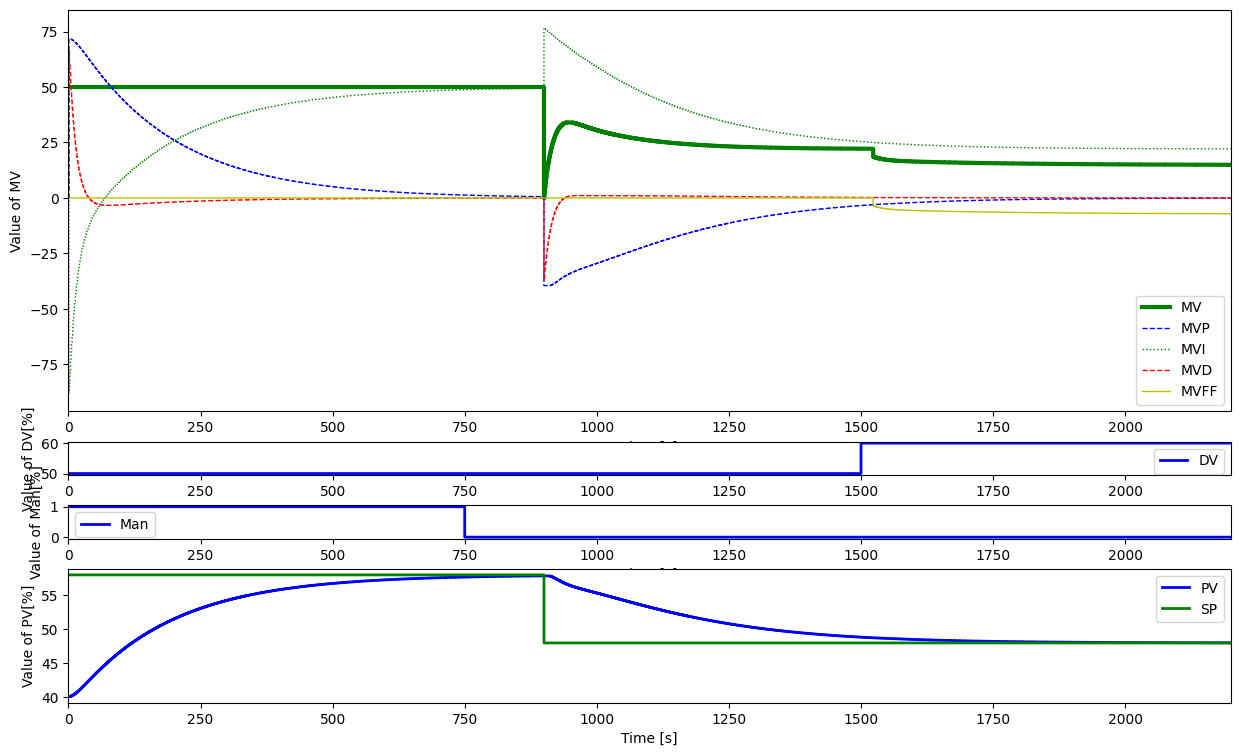

In [124]:
t = []
E = []
SP = []
DV = []
PV = []

MV = []
MVP = []
MVI = []
MVD = []

Man = []
MVMan = []
MVFF = []
MVFFDelay = []
MVFFLL1 = []

MVDelayp = []
PV1p = []
PV2p = []

MVDelayd = []
PV1d = []
PV2d = []

for i in range(0,N):
    t.append(i*Ts)

    # SP and DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    # Feedforward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-(Kd/Kp),T1,T1d,Ts,MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1,1,T2,T2d,Ts,MVFF)
    else:
        LL_RT(MVFFLL1,0,T2,T2d,Ts,MVFF)

    #PID controller
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    #PID control action
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)

    #Input-output dynamics P(s)
    Delay_RT(MV,thetap,Ts,MVDelayp,MV0)
    FO_RT(MVDelayp,Kp,T1,Ts,PV1p,0)
    FO_RT(PV1p,1,T2,Ts,PV2p,0)

    # Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(PV2p[-1] + PV2d[-1] + PV0 - Kp*MV0)
   
plt.figure(figsize = (15,9))
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 0.25, 0.25, 1])


plt.subplot(gs[0])
plt.step(t,MV,'g-',linewidth=3, label='MV',where='post')
plt.step(t,MVP,'b--',linewidth=1, label='MVP',where='post')

plt.step(t,MVI,'g:',linewidth=1, label='MVI',where='post')
plt.step(t,MVD,'r--',linewidth=1, label='MVD',where='post')
plt.step(t,MVFF,'y-',linewidth=1, label='MVFF',where='post')
plt.ylabel('Value of MV')
plt.xlabel('Time [s]')
plt.legend(loc='lower right')
plt.xlim([0, TSim])

plt.subplot(gs[1])
plt.step(t,DV,'b-',linewidth=2, label='DV',where='post')
plt.ylabel('Value of DV[%]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])  

plt.subplot(gs[2])
plt.step(t,Man,'b-',linewidth=2, label='Man',where='post')
plt.ylabel('Value of Man[%]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(gs[3])
plt.step(t,PV,'b-',linewidth=2, label='PV',where='post')
plt.step(t,SP,'g-',linewidth=2, label='SP',where='post')
plt.ylabel('Value of PV[%]')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim]) 